# Case 1. Patient Drug Review Analysis
**Neural Networks for Machine Learning Applications**\
Rabindra Manandhar

15.03.2024 - v1\
17.03.2024 - v2

Information Technology, Bachelor's Degree\
Metropolia University of Applied Sciences

## Introduction

In the realm of healthcare, understanding patient sentiment towards various medications is crucial for improving treatment outcomes and patient satisfaction. The UCI ML Drug Review dataset provides patient reviews on specific drugs along with related conditions and a 10-star patient rating system reflecting overall patient satisfaction.

The task is to use the methods of text processing and to experiment with convolutional (1D) neural network|s (or Transformer architecture) to create a multiclass classifier and predict these three classes (negative, neutral, positive) from the collection of patient drug reviews. To assess the performance of the classifier, the model should be evaluated with test data, and present the full confusion matrix together with the classification report and the most relevant metrics (accuracy + Cohen’s kappa) of this evaluation, with appropriate interpretations.


## Setup

In [3]:
# importing all necessary libraries

import time # for timing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Neural network libraries
import tensorflow as tf

# Preprocessing utilities
from sklearn.model_selection import train_test_split # preprocessing datasets
from tensorflow.keras.preprocessing.text import Tokenizer # text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences # text preprocessing
from tensorflow.keras.utils import to_categorical # for one-hot-encoding

# For modeling
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential # modeling neural networks
from tensorflow.keras.layers import Dense, Input, Activation, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.initializers import Constant

# Final metrics
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

## Dataset

Used dataset is from KUC(Kaggle University Club) Hackathon Winter 2018. 

It contains collection of patient drug reviews extracted from Drugs.com. Drugs.com is a comprehensive source of drug information online. In the dataset there is uniqueID for the review, name of the reviewed drug and condition where it's used, the text review, "star rating" from 1 to 10, review date and useful count to indicate number of others users that find the review useful.

The dataset is already split for training and testing by giving two csv files. The split is 75/25. The training data is split to train data and validation data later.

In [4]:
# Create dataframes train and test
train_df = pd.read_csv('drugsComTrain_raw.csv')
test_df = pd.read_csv('drugsComTest_raw.csv')

train_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


## Preprocessing

In [5]:
train_df.isnull().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [6]:
test_df.isnull().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

The datasets consist of missing values in 'condition' column. However, we are only interested in 'reviews' and 'ratings' columns, thus, we neglect the missing values of 'condition' column.

#### Tokenize the text data using keras tokenizer.

**`max_features`** - how many unique words are used from the text data\

In [7]:
%%time

num_words = 10000

# Tokenize the text
samples = train_df['review']
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(samples)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(samples)

# Print out the number of unique tokens
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

Found 51429 unique tokens.
CPU times: user 8.76 s, sys: 229 ms, total: 8.99 s
Wall time: 9.76 s


#### Pad sequences to ensure uniform length

**`sequence_length`** - the maximum length of the review. All reviews are zero-padded to this length

In [8]:
sequence_length = 200

data = pad_sequences(sequences, maxlen = sequence_length)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (161297, 200)


#### Categorize the ratings. Use 3 categories:

* when ratings > 6, then labels = positive = 2
* when ratings >= 5 and ratings <= 6, then labels = neutral = 1
* when ratings < 5, then labels = negative = 0

In [9]:
ratings = train_df['rating'].values
labels = 1.0*(ratings > 6) + 1.0*(ratings >= 5)

#### Split the training data to training and validation datasets. Use 75:25 rule.

In [10]:
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size = 0.25)

#### One-hot-code the labels.

In [11]:
train_cat = to_categorical(train_labels)
val_cat = to_categorical(val_labels)

## Model

Build and train a Convolutional Neural Network (CNN) model

In [12]:
embedding_dim = 100

# Define the model architecture with an LSTM layer
model = Sequential([
    Embedding(num_words + 1, embedding_dim),
    Dropout(0.25),
    Conv1D(128, 7, padding="valid", activation="relu", strides=3),
    LSTM(64, return_sequences=True),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    Dense(128, activation="relu"),
    Dense(3, activation='softmax')
])

# Compile
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['acc'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training

Traind the data. Use 10 epochs. Use %%time cell magic to count timing.

In [13]:
%%time
history = model.fit(train_data, train_cat,
          batch_size = 128,
          epochs = 10,
          validation_data=(val_data, val_cat))

Epoch 1/10
262/946 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - acc: 0.6563 - loss: 0.8580

KeyboardInterrupt: 

## Validation results

Standard graphics for loss function and accuracy.

In [14]:
class_names=['Negative', 'Neutral', 'Positive']

In [15]:
# Plot the accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
e = np.arange(len(acc)) + 1

plt.plot(e, acc, label = 'train')
plt.plot(e, val_acc, label = 'validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.figure()

plt.plot(e, loss, label = 'train')
plt.plot(e, val_loss, label = 'validation')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.show()

NameError: name 'history' is not defined

## Calculate metrics

As the output is one-hot-encoded, we convert them to numeric values with numpy.argmax function. Then we are ready to calculate the classification report.

1261/1261 [==============================] - 14s 11ms/step
              precision    recall  f1-score   support

    Negative       0.77      0.78      0.78     10112
     Neutral       0.50      0.30      0.37      3621
    Positive       0.89      0.93      0.91     26592

    accuracy                           0.84     40325
   macro avg       0.72      0.67      0.69     40325
weighted avg       0.82      0.84      0.83     40325



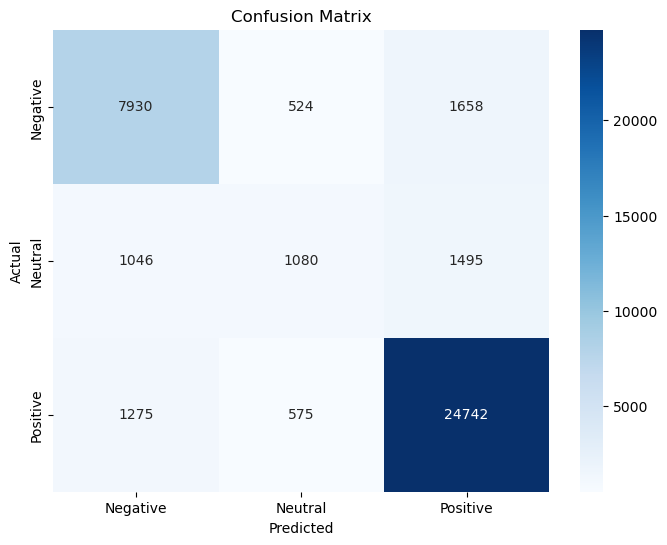

In [47]:
# Find the predicted values for the validation set
pred_labels = np.argmax(model.predict(val_data), axis = 1)
val_labels = np.argmax(val_cat, axis = 1)

# Calculate the classification report
cr = classification_report(val_labels, pred_labels,target_names=class_names)
print(cr)

# Calculate the confusion matrix and plot it 
cm = confusion_matrix(val_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The original Grässer et al. (2018) article used Cohen's kappa metrics to illustrate the validity of the model.

In [48]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(val_labels, pred_labels)
print(f"Cohen's kappa (linear)    = {k:.4f}")
k2 = cohen_kappa_score(val_labels, pred_labels, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.4f}")

Cohen's kappa (linear)    = 0.6570
Cohen's kappa (quadratic) = 0.7456


## Discussion and conclusions

This approach utilizes a simple CNN model for text classification, which can be effective for tasks like sentiment analysis. Adjustments to the architecture and hyperparameters may further improve performance.

The convolutional neural network (CNN) model developed for text classification achieved promising results in predicting patient sentiment towards various medications based on drug reviews. The model demonstrated an accuracy of approximately 84% on the validation dataset. However, it's essential to delve deeper into the evaluation metrics to gain a comprehensive understanding of its performance.

In conclusion, this study demonstrates the applicability of CNN models for sentiment analysis of patient drug reviews. While the developed model exhibits promising performance, continuous refinement and exploration of alternative methodologies are essential for advancing the accuracy and robustness of sentiment analysis in healthcare applications.